In [239]:
from typing import Tuple

import chex
from jumanji import specs, Environment
from jumanji.env import State
from jumanji.types import TimeStep, restart, termination, transition
from jumanji.viewer import Viewer
import jumanji
from jax.tree_util import tree_map
from chex import dataclass
import jax.numpy as jnp
import jax
import matplotlib
from numpy.typing import NDArray

from typing import NamedTuple



In [240]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [241]:
from bin.game_interfaces_binding import Game, GameState, GameAction, GameOptions, ActionType, SubActionType, TileMask, Craftsman, MapState

In [242]:
class EnvPosition(NamedTuple):
    x: chex.Array  
    y: chex.Array 

class EnvAgent(NamedTuple):
    position: EnvPosition
    id: chex.Array
    is_t1: chex.Array

@dataclass
class State:
    # map: chex.Array # (map_height, map_width) 

    is_pond: chex.Array
    is_castle: chex.Array
    has_t1_wall: chex.Array
    has_t2_wall: chex.Array
    has_t1_craftsman: chex.Array
    has_t2_craftsman: chex.Array
    is_t1_close_territory: chex.Array
    is_t2_close_territory: chex.Array
    is_t1_open_territory: chex.Array
    is_t2_open_territory: chex.Array

    agents: chex.Array # (num_agents:Agent)
    current_turn: chex.Array # ()
    remaining_turns: chex.Array # ()
    is_t1_turn: chex.Array # ()
    key: chex.PRNGKey # (2,)

class EnvAction(NamedTuple):
    action: chex.Array # ()
    craftsman_id: chex.Array # ()

class Observation(NamedTuple):
    # map: chex.Array # (map_height, map_width) 

    is_pond: chex.Array
    is_castle: chex.Array
    has_t1_wall: chex.Array
    has_t2_wall: chex.Array
    has_t1_craftsman: chex.Array
    has_t2_craftsman: chex.Array
    is_t1_close_territory: chex.Array
    is_t2_close_territory: chex.Array
    is_t1_open_territory: chex.Array
    is_t2_open_territory: chex.Array

    agents: chex.Array # (num_agents:Agent)
    current_turn: chex.Array # ()
    remaining_turns: chex.Array # ()
    is_t1_turn: chex.Array # ()

In [242]:
from datetime import datetime
from typing import Optional, Sequence

import matplotlib
import matplotlib.animation
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from numpy.typing import NDArray
from jumanji.environments.commons.maze_utils.maze_rendering import MazeViewer
from PIL import Image


from enum import Enum
 
class ScoreType(Enum):
    T1_OPEN_TERRITORY = 0
    T2_OPEN_TERRITORY = 1
    T1_CLOSE_TERRITORY = 2
    T2_CLOSE_TERRITORY = 3
    T1_WALL = 4
    T2_WALL = 5
    T1_CASTLE = 6
    T2_CASTLE = 7
    T1 = 8
    T2 = 9

def calculate_score(state: State, game_options: GameOptions):
    width = state.is_pond.shape[1]
    height = state.is_pond.shape[0]

    res = {
        ScoreType.T1_OPEN_TERRITORY: 0,
        ScoreType.T2_OPEN_TERRITORY: 0,
        ScoreType.T1_CLOSE_TERRITORY: 0,
        ScoreType.T2_CLOSE_TERRITORY: 0,
        ScoreType.T1_WALL: 0,
        ScoreType.T2_WALL: 0,
        ScoreType.T1_CASTLE: 0,
        ScoreType.T2_CASTLE: 0,
        ScoreType.T1: 0,
        ScoreType.T2: 0,
    }

    for row in range(height):
        for col in range(width):
            if state.is_t1_close_territory[row, col] or state.is_t1_open_territory[row, col]:
                if state.is_t1_close_territory[row, col]:
                    res[ScoreType.T1_CLOSE_TERRITORY] += game_options.territoryCoeff
                else:
                    res[ScoreType.T1_OPEN_TERRITORY] += game_options.territoryCoeff
                if state.is_castle[row, col]:
                    res[ScoreType.T1_CASTLE] += game_options.castleCoeff
            elif state.is_t2_close_territory[row, col] or state.is_t2_open_territory[row, col]:
                if state.is_t2_close_territory[row, col]:
                    res[ScoreType.T2_CLOSE_TERRITORY] += game_options.territoryCoeff
                else:
                    res[ScoreType.T2_OPEN_TERRITORY] += game_options.territoryCoeff
                if state.is_castle[row, col]:
                    res[ScoreType.T2_CASTLE] += game_options.castleCoeff
            elif state.has_t1_wall[row, col]:
                res[ScoreType.T1_WALL] += game_options.wallCoeff
            elif state.has_t2_wall[row, col]:
                res[ScoreType.T2_WALL] += game_options.wallCoeff
    
    res[ScoreType.T1] = res[ScoreType.T1_OPEN_TERRITORY] + res[ScoreType.T1_CLOSE_TERRITORY] + res[ScoreType.T1_WALL] + res[ScoreType.T1_CASTLE]
    res[ScoreType.T2] = res[ScoreType.T2_OPEN_TERRITORY] + res[ScoreType.T2_CLOSE_TERRITORY] + res[ScoreType.T2_WALL] + res[ScoreType.T2_CASTLE]

    return res

%matplotlib inline
class ProconViewer(MazeViewer):
    COLORS = {
        "T1_WALL": [0, 0.024, 0.671],
        "T1_CLOSE_TERRITORY": [0.133, 0.161, 1],
        "T1_OPEN_TERRITORY": [0.573, 0.62, 1],
        "T1_CRAFTSMAN": [0.278, 0.922, 0.906],
        "T2_WALL": [0.569, 0, 0],
        "T2_CLOSE_TERRITORY": [1, 0, 0],
        "T2_OPEN_TERRITORY": [1, 0.635, 0.635],
        "T2_CRAFTSMAN": [0.922, 0.278, 0.58],
        "CASTLE": [0.988, 0.91, 0.145],
        "POND": [0,0,0],
    }

    def __init__(self, name: str, render_mode: str = "human") -> None:
        """
        Viewer for the `Procon` environment.

        Args:
            name: the window name to be used when initialising the window.
            render_mode: the mode used to render the environment. Must be one of:
                - "human": render the environment on screen.
                - "rgb_array": return a numpy array frame representing the environment.
        """
        super().__init__(name, render_mode)

        image_names = [
            "c1",
            "c2",
        ]

        self._images = {name: Image.open(f"assets/{name}.png").resize((8,8)) for name in image_names}
        
    def render_with_score(self, state: State, game_options: GameOptions) -> Optional[NDArray]:
        self._clear_display()
        fig, ax = self._get_fig_ax()
        ax.clear()
        self._add_grid_image(state, ax)

        score = calculate_score(state, game_options)
        fig.suptitle(f"Procon - Territory: {game_options.territoryCoeff}, Wall: {game_options.wallCoeff}, Castle: {game_options.castleCoeff}, Turns: {game_options.maxTurns} - {datetime.now().strftime('%H:%M:%S %d-%m-%Y')}")
        ax.set_title(f"Turn {state.current_turn} - Team 1: {score[ScoreType.T1]}, Team 2: {score[ScoreType.T2]}\nT1 - Close: {score[ScoreType.T1_CLOSE_TERRITORY]}, Open: {score[ScoreType.T1_OPEN_TERRITORY]}, Wall: {score[ScoreType.T1_WALL]}, Castle: {score[ScoreType.T1_CASTLE]}\nT2 - Close: {score[ScoreType.T2_CLOSE_TERRITORY]}, Open: {score[ScoreType.T2_OPEN_TERRITORY]}, Wall: {score[ScoreType.T2_WALL]}, Castle: {score[ScoreType.T2_CASTLE]}")
        return self._display(fig)

    def animate_with_score(
        self,
        states: Sequence[State],
        game_options: GameOptions,
        interval: int = 200,
        save_path: Optional[str] = None,
    ) -> matplotlib.animation.FuncAnimation:
        fig, ax = plt.subplots(num=f"{self._name}Animation", figsize=self.FIGURE_SIZE)
        plt.close(fig)


        fig.suptitle(f"Procon - Territory: {game_options.territoryCoeff}, Wall: {game_options.wallCoeff}, Castle: {game_options.castleCoeff}, Turns: {game_options.maxTurns} - {datetime.now().strftime('%H:%M:%S %d-%m-%Y')}")

        def make_frame(state_index: int) -> None:
            ax.clear()
            state = states[state_index]
            self._add_grid_image(state, ax)
            score = calculate_score(state, game_options)
            ax.set_title(f"Turn {state.current_turn} - Team 1: {score[ScoreType.T1]}, Team 2: {score[ScoreType.T2]}\nT1 - Close: {score[ScoreType.T1_CLOSE_TERRITORY]}, Open: {score[ScoreType.T1_OPEN_TERRITORY]}, Wall: {score[ScoreType.T1_WALL]}, Castle: {score[ScoreType.T1_CASTLE]}\nT2 - Close: {score[ScoreType.T2_CLOSE_TERRITORY]}, Open: {score[ScoreType.T2_OPEN_TERRITORY]}, Wall: {score[ScoreType.T2_WALL]}, Castle: {score[ScoreType.T2_CASTLE]}")

        # Create the animation object.
        self._animation = matplotlib.animation.FuncAnimation(
            fig,
            make_frame,
            frames=len(states),
            interval=interval,
        )

        # Save the animation as a gif.
        if save_path:
            self._animation.save(save_path)

        return self._animation


    def _create_grid_image(self, state: State) -> NDArray:
        img = np.ones((*state.has_t1_wall.shape, 3))

        img[state.is_t1_open_territory] = self.COLORS["T1_OPEN_TERRITORY"]
        img[state.is_t2_open_territory] = self.COLORS["T2_OPEN_TERRITORY"]
        img[state.is_t1_close_territory] = self.COLORS["T1_CLOSE_TERRITORY"]
        img[state.is_t2_close_territory] = self.COLORS["T2_CLOSE_TERRITORY"]

        img[state.has_t1_wall] = self.COLORS["T1_WALL"]
        img[state.has_t2_wall] = self.COLORS["T2_WALL"]

        img[state.is_castle] = self.COLORS["CASTLE"]
        img[state.is_pond] = self.COLORS["POND"]


        # img[state.has_t1_craftsman] = self.COLORS["T1_CRAFTSMAN"]
        # img[state.has_t2_craftsman] = self.COLORS["T2_CRAFTSMAN"]

        # add a transparent layer
        img = np.dstack([img, np.ones(img.shape[:2])])

        # upscale array by 8 times
        img = np.kron(img, np.ones((8, 8, 1)))

        img = Image.fromarray((img * 255).astype('uint8'))

        # paste the craftsman on top
        for agent in state.agents:
            if agent.is_t1:
                img.paste(self._images["c1"], (agent.position.x*8, agent.position.y*8), self._images["c1"])
            else:
                img.paste(self._images["c2"], (agent.position.x*8, agent.position.y*8), self._images["c2"])
        
        img = np.array(img)

        img = self._draw_black_frame_around(img)

        return img


    def _draw_black_frame_around(self, img: NDArray) -> NDArray:
        img = np.pad(img, ((8, 8), (8, 8), (0, 0)),mode='constant', constant_values=255)
        img[:8, :, :3] = img[-8:, :, :3] = img[:, :8, :3] = img[:, -8:, :3] = 0
        return img

In [243]:
idxToActionEnum = [
    [ActionType.MOVE, SubActionType.MOVE_UP],
    [ActionType.MOVE, SubActionType.MOVE_DOWN],
    [ActionType.MOVE, SubActionType.MOVE_LEFT],
    [ActionType.MOVE, SubActionType.MOVE_RIGHT],
    [ActionType.MOVE, SubActionType.MOVE_UP_LEFT],
    [ActionType.MOVE, SubActionType.MOVE_UP_RIGHT],
    [ActionType.MOVE, SubActionType.MOVE_DOWN_LEFT],
    [ActionType.MOVE, SubActionType.MOVE_DOWN_RIGHT],
    [ActionType.BUILD, SubActionType.BUILD_UP],
    [ActionType.BUILD, SubActionType.BUILD_DOWN],
    [ActionType.BUILD, SubActionType.BUILD_LEFT],
    [ActionType.BUILD, SubActionType.BUILD_RIGHT],
    [ActionType.DESTROY, SubActionType.DESTROY_UP],
    [ActionType.DESTROY, SubActionType.DESTROY_DOWN],
    [ActionType.DESTROY, SubActionType.DESTROY_LEFT],
    [ActionType.DESTROY, SubActionType.DESTROY_RIGHT],
    [ActionType.STAY, SubActionType.STAY],
]

def map_tile_to_bitmask(tile):
    if tile == 1:
        return 1 << TileMask.POND.value
    elif tile == 2:
        return 1 << TileMask.CASTLE.value
    return 0

In [244]:

max_possible_actions = 17

class ProconJumanji(Environment[State]):
    def __init__(self, gameOptions: GameOptions, map, craftsmen):
        self.max_turns = gameOptions.maxTurns
        self.map_width = gameOptions.mapWidth
        self.map_height = gameOptions.mapHeight

        self.wall_coeff = gameOptions.wallCoeff
        self.castle_coeff = gameOptions.castleCoeff
        self.territory_coeff = gameOptions.territoryCoeff

        self.num_agents = len(craftsmen)

        self.game = Game(gameOptions, map, craftsmen)
        self.game_options = gameOptions

        self._viewer = ProconViewer("Procon", render_mode="human")

        self.initial_state = self._game_state_to_env_state(self.game.getCurrentState())

    def __repr__(self) -> str:
        return (
            f"Procon(\n"
            f"\tmap_width={self.map_width},\n"
            f"\tmap_height={self.map_height},\n"
            f"\tnum_agents={self.num_agents!r}, \n"
            ")"
        )

    def reset(self, key: chex.PRNGKey) -> Tuple[State, TimeStep]:
        state = self.initial_state
        timestep = restart(observation=self._env_state_to_observation(state), extras=None)

        return state, timestep
        

    def step(self, state: State, actions: chex.Array) -> Tuple[State, TimeStep[Observation]]:
        game_state = self._env_state_to_game_state(state)
        game_actions = self._env_actions_to_game_actions(actions)
        
        next_game_state = game_state.applyActions(game_actions)

        print(actions)

        for game_action in game_actions:
            print(game_action.craftsmanId, game_action.actionType, game_action.subActionType)

        print(next_game_state.map.calcPoints(self.game.gameOptions, True), next_game_state.map.calcPoints(self.game.gameOptions, False))

        next_env_state = self._game_state_to_env_state(next_game_state)

        next_observation = self._env_state_to_observation(next_env_state)

        t1_score_prev, t2_score_prev = game_state.map.calcPoints(self.game.gameOptions, True), game_state.map.calcPoints(self.game.gameOptions, False)
        t1_score_next, t2_score_next = next_game_state.map.calcPoints(self.game.gameOptions, True), next_game_state.map.calcPoints(self.game.gameOptions, False)

        reward = np.array([t1_score_next - t1_score_prev, t2_score_next - t2_score_prev])
        done = game_state.turn >= self.max_turns

        # timestep = jax.lax.cond(
        #     done,
        #     lambda reward, observation, extras: termination(
        #         reward=reward,
        #         observation=observation,
        #         extras=extras,
        #     ),
        #     lambda reward, observation, extras: transition(
        #         reward=reward,
        #         observation=observation,
        #         extras=extras,
        #     ),
        #     reward,
        #     next_observation,
        #     None,
        # )

        timestep = termination(
                reward=reward,
                observation=next_observation,
                extras=None,
        ) if done else transition(
            reward=reward,
            observation=next_observation,
            extras=None,
        )

        return next_env_state, timestep



    def observation_spec(self) -> specs.Spec[Observation]:
        """agent encoding: (x, y, id, is_t1)"""
        def boolArrayOfMapSize(name: str):
            return specs.BoundedArray(
                shape=(self.map_height, self.map_width), 
                dtype=bool, 
                minimum=False, 
                maximum=True, 
                name=name
            )

        return specs.Spec(
            Observation,
            "ObservationSpec",
            is_pond=boolArrayOfMapSize("is_pond"),
            is_castle=boolArrayOfMapSize("is_castle"),
            has_t1_wall=boolArrayOfMapSize("has_t1_wall"),
            has_t2_wall=boolArrayOfMapSize("has_t2_wall"),
            has_t1_craftsman=boolArrayOfMapSize("has_t1_craftsman"),
            has_t2_craftsman=boolArrayOfMapSize("has_t2_craftsman"),
            is_t1_close_territory=boolArrayOfMapSize("is_t1_close_territory"),
            is_t2_close_territory=boolArrayOfMapSize("is_t2_close_territory"),
            is_t1_open_territory=boolArrayOfMapSize("is_t1_open_territory"),
            is_t2_open_territory=boolArrayOfMapSize("is_t2_open_territory"),
            
            agents=specs.Array((self.num_agents, 4), dtype=jnp.int32, name="agents"),
            current_turn=specs.BoundedArray((), dtype=jnp.int32, minimum=0, maximum=self.max_turns, name="current_turn"),
            remaining_turns=specs.BoundedArray((), dtype=jnp.int32, minimum=0, maximum=self.max_turns, name="remaining_turns"),
            is_t1_turn=specs.BoundedArray((), dtype=bool, minimum=False, maximum=True, name="is_t1_turn"),
        )

    def action_spec(self) -> specs.Spec:
        # (action + craftsman_id) in an array so that their is an order
        return specs.MultiDiscreteArray(num_values=jnp.array([[max_possible_actions, self.num_agents]]*self.num_agents, dtype=jnp.int32), name="action")
    
    def _game_state_to_env_state(self, game_state: GameState) -> State:
        map_state = game_state.map
        map = np.array(map_state.tiles)

        agents = [EnvAgent(EnvPosition(craftsman.x, craftsman.y), craftsman.id, craftsman.isT1) for (id, craftsman) in game_state.craftsmen.items()]

        state = State(
            is_pond=map & (1 << TileMask.POND.value) > 0,
            is_castle=map & (1 << TileMask.CASTLE.value) > 0,
            has_t1_wall=map & (1 << TileMask.T1_WALL.value) > 0,
            has_t2_wall=map & (1 << TileMask.T2_WALL.value) > 0,
            has_t1_craftsman=map & (1 << TileMask.T1_CRAFTSMAN.value) > 0,
            has_t2_craftsman=map & (1 << TileMask.T2_CRAFTSMAN.value) > 0,
            is_t1_close_territory=map & (1 << TileMask.T1_CLOSE_TERRITORY.value) > 0,
            is_t2_close_territory=map & (1 << TileMask.T2_CLOSE_TERRITORY.value) > 0,
            is_t1_open_territory=map & (1 << TileMask.T1_OPEN_TERRITORY.value) > 0,
            is_t2_open_territory=map & (1 << TileMask.T2_OPEN_TERRITORY.value) > 0,

            agents=agents,
            current_turn=game_state.turn,
            remaining_turns=self.max_turns - game_state.turn,
            is_t1_turn=game_state.isT1Turn,
            key=jax.random.PRNGKey(0), # TODO: fix this
        )
        return state

    def _env_state_to_game_state(self, env_state: State) -> GameState:
        go = self.game.gameOptions
        map_state = MapState(go.mapWidth, go.mapHeight)
        map = np.zeros_like(np.array(map_state.tiles), dtype=jnp.int32)

        map |= env_state.is_pond << TileMask.POND.value
        map |= env_state.is_castle << TileMask.CASTLE.value
        map |= env_state.has_t1_wall << TileMask.T1_WALL.value
        map |= env_state.has_t2_wall << TileMask.T2_WALL.value
        map |= env_state.has_t1_craftsman << TileMask.T1_CRAFTSMAN.value
        map |= env_state.has_t2_craftsman << TileMask.T2_CRAFTSMAN.value
        map |= env_state.is_t1_close_territory << TileMask.T1_CLOSE_TERRITORY.value
        map |= env_state.is_t2_close_territory << TileMask.T2_CLOSE_TERRITORY.value
        map |= env_state.is_t1_open_territory << TileMask.T1_OPEN_TERRITORY.value
        map |= env_state.is_t2_open_territory << TileMask.T2_OPEN_TERRITORY.value


        map_state.tiles = map.tolist()

        craftsmen = {int(craftsman.id): Craftsman(craftsman.id, craftsman.position.x, craftsman.position.y, craftsman.is_t1) for craftsman in env_state.agents}

        game_state = GameState(map_state, craftsmen, env_state.current_turn, env_state.is_t1_turn)
        return game_state


    def _env_state_to_observation(self, env_state: State) -> Observation:
        return Observation(
            is_pond=env_state.is_pond,
            is_castle=env_state.is_castle,
            has_t1_wall=env_state.has_t1_wall,
            has_t2_wall=env_state.has_t2_wall,
            has_t1_craftsman=env_state.has_t1_craftsman,
            has_t2_craftsman=env_state.has_t2_craftsman,
            is_t1_close_territory=env_state.is_t1_close_territory,
            is_t2_close_territory=env_state.is_t2_close_territory,
            is_t1_open_territory=env_state.is_t1_open_territory,
            is_t2_open_territory=env_state.is_t2_open_territory,
            agents=env_state.agents,
            current_turn=env_state.current_turn,
            remaining_turns=env_state.remaining_turns,
            is_t1_turn=env_state.is_t1_turn,
        )

    def _env_action_to_game_action(self, env_action: EnvAction) -> GameAction:
        return GameAction(env_action.craftsman_id, *idxToActionEnum[env_action.action])

    def _env_actions_to_game_actions(self, env_actions: chex.Array) -> chex.Array:
        return [self._env_action_to_game_action(env_action) for env_action in env_actions]


    def render(self, state: State) -> Optional[NDArray]:
        return self._viewer.render_with_score(state, self.game_options)

    def animate(
        self,
        states: Sequence[State],
        interval: int = 200,
        save_path: Optional[str] = None,
    ) -> matplotlib.animation.FuncAnimation:
        return self._viewer.animate_with_score(states, self.game_options, interval, save_path)


In [245]:

action_path = "test-cases/match-259.txt"
map_path = "test-cases/map-259-game-2.txt"

from utils import load_map

mapdata = load_map(map_path)
map_formatted = [[map_tile_to_bitmask(x) for x in row] for row in mapdata['game_map']]


counter = 0
craftsman_strid_to_intid = {}
craftsmen_formatted = []
for c in mapdata['craftsmen']['team1']:
    new_craftsman = Craftsman(counter, c['x'], c['y'], True)
    craftsmen_formatted.append(new_craftsman)
    craftsman_strid_to_intid[c['id']] = counter
    counter += 1
for c in mapdata['craftsmen']['team2']:
    new_craftsman = Craftsman(counter, c['x'], c['y'], False)
    craftsmen_formatted.append(new_craftsman)
    craftsman_strid_to_intid[c['id']] = counter
    counter += 1


actiontxt = open(action_path, "r").read()

# Split the input string based on "- -"
turns = actiontxt.strip().split("- -")
turns = [section.strip() for section in turns]

# Convert each section to an array of arrays
actions = [[action.split(' ') for action in (turn.split('\n') if turn else [])] for turn in turns]
actions = [[GameAction(craftsman_strid_to_intid[action[0]], *idxToActionEnum[int(action[1])]) for action in turn] for turn in actions]

# %%
go = GameOptions()
go.mapWidth = mapdata['game_settings']['map_width']
go.mapHeight = mapdata['game_settings']['map_height']
go.maxTurns = mapdata['game_settings']['max_turn']
go.wallCoeff = mapdata['score_coefficients']['wall']
go.castleCoeff = mapdata['score_coefficients']['castle']
go.territoryCoeff = mapdata['score_coefficients']['territory']

[EnvAction(action=5, craftsman_id=0), EnvAction(action=4, craftsman_id=2), EnvAction(action=2, craftsman_id=3), EnvAction(action=4, craftsman_id=1)]
0 ActionType.MOVE SubActionType.MOVE_UP_RIGHT
2 ActionType.MOVE SubActionType.MOVE_UP_LEFT
3 ActionType.MOVE SubActionType.MOVE_LEFT
1 ActionType.MOVE SubActionType.MOVE_UP_LEFT
0 0
[EnvAction(action=3, craftsman_id=4), EnvAction(action=1, craftsman_id=5), EnvAction(action=10, craftsman_id=6), EnvAction(action=10, craftsman_id=7)]
4 ActionType.MOVE SubActionType.MOVE_RIGHT
5 ActionType.MOVE SubActionType.MOVE_DOWN
6 ActionType.BUILD SubActionType.BUILD_LEFT
7 ActionType.BUILD SubActionType.BUILD_LEFT
0 2
[EnvAction(action=9, craftsman_id=0), EnvAction(action=4, craftsman_id=1), EnvAction(action=4, craftsman_id=2), EnvAction(action=9, craftsman_id=3)]
0 ActionType.BUILD SubActionType.BUILD_DOWN
1 ActionType.MOVE SubActionType.MOVE_UP_LEFT
2 ActionType.MOVE SubActionType.MOVE_UP_LEFT
3 ActionType.BUILD SubActionType.BUILD_DOWN
2 2
[EnvAction

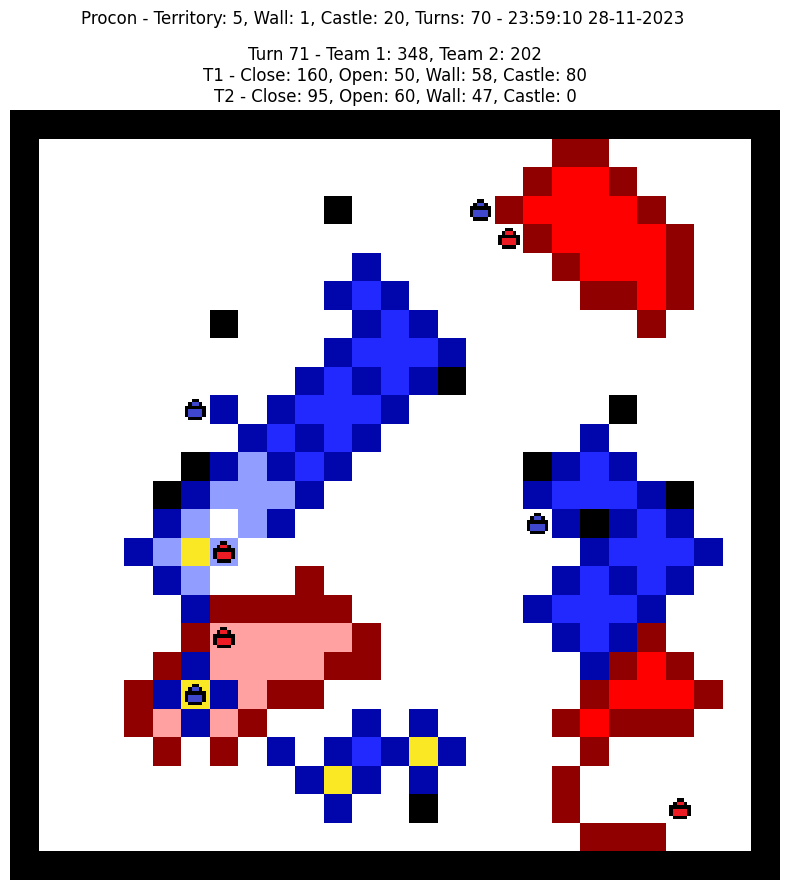

In [246]:
env = ProconJumanji(go, map_formatted, craftsmen_formatted)

random_key = jax.random.PRNGKey(0)
key1, key2 = jax.random.split(random_key)
batch_size = 1

keys = jax.random.split(key1, batch_size)
state, timestep = env.reset(keys[0])

def game_actions_to_env_actions(all_turns_actions):
    env_all_turns_actions = []
    for actions in all_turns_actions:
        turn_actions = []
        for action in actions:
            turn_actions.append(EnvAction(action.subActionType.value, action.craftsmanId))
        env_all_turns_actions.append(turn_actions)
            
    return env_all_turns_actions

env_actions = game_actions_to_env_actions(actions)

state_list = [state]

for i, actions_in_turn in enumerate(env_actions):
    # print(actions_in_turn)
    state, timestep = env.step(state, actions_in_turn)
    state_list.append(state)
env.animate(state_list, interval=200, save_path=f'records/test.gif')
env.render(state_list[-1])
    
